# Problem 6. Multilayer Perceptrons with PyTorch

- In this homework you will train (again) a multilayer perceptron

- But differently from what you did in `Problem 5`, since this time, you will let the `PyTorch` library do most of the complicated work for you

- The goal of this notebook is to make you get familiar with `PyTorch` and the its main concepts, that we will use repeatedly along the course.

- We will be training a multilayer perceptron on the `CIFAR-10` dataset, a popular dataset of images that is used in Computer-Vision (CV) research

- You will need to use a lot the documentation of `PyTorch` and look at examples for this notebook.

In [1]:
import torch, torchvision
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 

## Problem 6A: Load the dataset

- `PyTorch` provides popular computer vision datasets that can be easily downloaded
- The following code will download the `CIFAR-10` dataset for us  
- Since it is computationally expensive to load the entire dataset into memory, we will use `PyTorch`'s dataloaders  before feeding batches of images to the neural network

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
testset = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

batch_size = 16
# You should use as many cores you have on your laptop
num_workers = 32

# Fill in the options for both data loaders. Warning: the training dataloader should shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
testloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize the Images of CIFAR-10

* Once everything is properly loaded you should be able to visualize some of the samples of the CIFAR-10

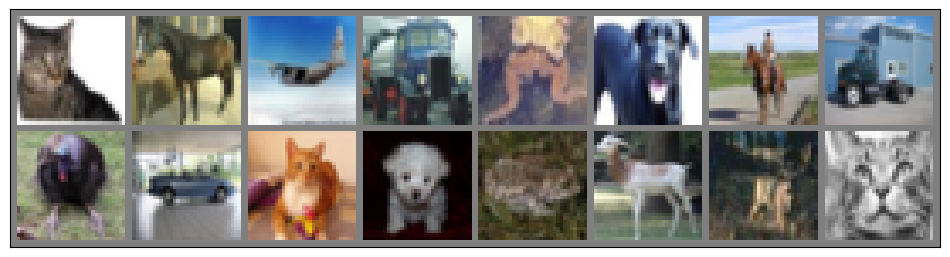

  cat horse plane truck  frog   dog horse truck  bird   car   cat   dog  frog  deer  deer   cat


In [10]:
def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Problem 6B. Creating an MLP model

- We are now ready to define all the necessary hyperparameters that are required to construct a proper MLP
- Similarly to what we did in `Problem 5` we need to explore the data carefully in order to know how to set the following parameters

### Hyperparameters

Choose suitable hyperparameters.

In [ ]:
input_dim = ?
hidden_dim = ?
output_dim = ?
learning_rate = ?
num_epochs = ?

### Define the Network

- You are free to define any kind of architecture that you think is reasonable for the problem of classifying CIFAR-10 images
- By default, you can use a multi-layer perceptron
- The constructor of the neural network will represent the different components of the computation-graph, note that it is very similar to the way we have programmed our own neural network in `Problem 5`.
- You will also have to define the forward pass yourself.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()

        ???
        
    def forward(self, x):
        ???

## Problem 6C: Instantiate and Train the Network

- You are now ready to create your neural network object
- You will also have to define an appropriate loss function to minimize and an optimization algorithm
- By default, you can use the cross-entropy loss and the RMS prop optimizer

In [ ]:
model = Net(?, ?, ?)
criterion = ?
optimizer = ?

### Train the Network

- Once you have your neural network you just need to train it. 
- You will have to compute the output of the forward pass, compare it to your desired output and update the parameters of the network by backpropagation. 
- Fortunately this time, this only requires less than 5 lines of code in `PyTorch`

In [ ]:
def train(num_epochs):
    for i in range(num_epochs):
        ???

In [ ]:
train(num_epochs)

- Of course, repeated calls to `train` will continue training from where it were
- Training a neural network is a highly iterative process.

## Problem 6D: Evaluate the final performance of the Network

- Once you think your network is properly trained, you will test its performance on the testing-set of the CIFAR-10 dataset
- Compute the final accuracy of your model
- You should be able to reach a 50% accuracy with a simple multi-layer perceptron

In [ ]:
def test():
    

In [ ]:
test()

**Final remark.** Of course, this is far from being the state-of-the-art. Indeed, convolutional neural nets are the backbones for computer vision problems (we will do it in following labs), while we only used here a feed-forward network.

## Bonus: Redo it using `pytorch-lightning`

There is some boilerplates in pure `PyTorch` code. The `pytorch-lighting` library is a new library allowing to simplify a lot the use of `PyTorch` together with very nice options for faster training and development.

**QUESTION**. Recode your neural network and its training using `pytorch-lightning`.